# Download Dataset

In [7]:
# !rm -rf benchmark_velocity_train benchmark_velocity_train.zip
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/2/benchmark_velocity_train.zip
# !unzip -q benchmark_velocity_train.zip -d ./benchmark_velocity_train

In [8]:
# !rm -rf benchmark_velocity_test benchmark_velocity_test.zip
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/2/benchmark_velocity_test.zip
# !unzip -q benchmark_velocity_test.zip -d ./benchmark_velocity_test

In [9]:
# !rm gt.json
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/truth/2/gt.json

# Import Libraries

In [10]:
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from sklearn import preprocessing

# Extract Training and Test Bounding Boxes

In [11]:
# def get_annotations_test(root_dir):
#   train_set = []
#   for clip in os.listdir(os.path.join(root_dir, 'clips')):
#     vehicles = []
#     with open(os.path.join(root_dir, 'clips', clip, 'annotation.json'), 'r') as f:
#       vehicles = json.load(f)
#     train_set.extend(vehicles)
#   return train_set

In [12]:
# train_set = get_annotations_test('./benchmark_velocity_train')

In [13]:
# with open('train_set.json', 'w') as f:
#   json.dump(train_set, f, indent=2)

In [14]:
# def get_annotations_test(json_file):
#   test_set = []
#   samples = []
#   with open(json_file, 'r') as f:
#     samples = json.load(f)
#   for vehicles in samples:
#     test_set.extend(vehicles)
#   return test_set

In [15]:
# test_set = get_annotations_test('./gt.json')

In [16]:
# with open('test_set.json', 'w') as f:
#   json.dump(test_set, f, indent=2)

# Load Training and Test Bounding Boxes From Disk

In [17]:
with open('train_set.json', 'r') as f:
  train_set = json.load(f)

In [18]:
print(json.dumps(train_set[0], indent=2))
print(len(train_set))

{
  "velocity": [
    -1.8863674079,
    -0.2654476548
  ],
  "bbox": {
    "top": 348.3208007812,
    "right": 699.1054077148,
    "bottom": 372.4557189941,
    "left": 668.4575805664
  },
  "position": [
    41.5328684316,
    -0.2388034841
  ]
}
1442


In [19]:
with open('test_set.json', 'r') as f:
  test_set = json.load(f)

In [20]:
print(test_set[0])
print(len(test_set))

{'velocity': [0.0478322246, 0.3102465833], 'bbox': {'top': 341.8059692383, 'right': 569.046081543, 'left': 509.4688110352, 'bottom': 384.0069274902}, 'position': [29.519410428, -6.0695901631]}
375


# Convert Train and Test Dicts Into Pandas Dataframes

In [21]:
def get_bbox_x(sample):
  return sample['bbox']['left']

def get_bbox_y(sample):
  return sample['bbox']['bottom']

def get_bbox_w(sample):
  return sample['bbox']['right'] - sample['bbox']['left']

def get_bbox_h(sample):
  return sample['bbox']['bottom'] - sample['bbox']['top']

def get_pos_z(sample):
  return sample['position'][0]

def get_pos_x(sample):
  return sample['position'][1]

def make_pd_row(sample):
  row = []
  row.append(get_bbox_x(sample))
  row.append(get_bbox_y(sample))
  row.append(get_bbox_w(sample))
  row.append(get_bbox_h(sample))
  row.append(get_pos_z(sample))
  row.append(get_pos_x(sample))
  return row

In [22]:
train_dataset = pd.DataFrame(columns=['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'pos_z', 'pos_x'])
for i in range(len(train_set)):
  train_dataset.loc[i] = make_pd_row(train_set[i])

In [23]:
test_dataset = pd.DataFrame(columns=['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'pos_z', 'pos_x'])
for i in range(len(test_set)):
  test_dataset.loc[i] = make_pd_row(test_set[i])

In [24]:
train_dataset.tail()

,bbox_x,bbox_y,bbox_w,bbox_h,pos_z,pos_x
1437,1046.741211,406.767700,168.736328,66.928101,14.692977,8.889901
1438,773.009827,365.354767,39.833374,25.436249,40.494133,5.500969
1439,706.252197,366.899445,35.494751,32.151764,44.793174,1.314025
1440,740.595398,361.888641,31.212524,21.840363,56.692773,5.480445
1441,572.182068,371.794312,29.412231,22.727081,49.080213,-6.737765


In [25]:
test_dataset.tail()

,bbox_x,bbox_y,bbox_w,bbox_h,pos_z,pos_x
370,596.311401,384.143127,50.038757,36.870026,29.080471,-2.712433
371,686.086121,389.359009,74.326416,75.383423,23.094960,-0.390961
372,728.255493,368.727081,30.102661,24.745697,43.586416,2.367466
373,803.424011,370.364624,42.303345,26.000122,39.631952,7.382388
374,658.999817,380.924774,50.237305,35.684174,28.729463,-0.344463


# Pairwise Plots

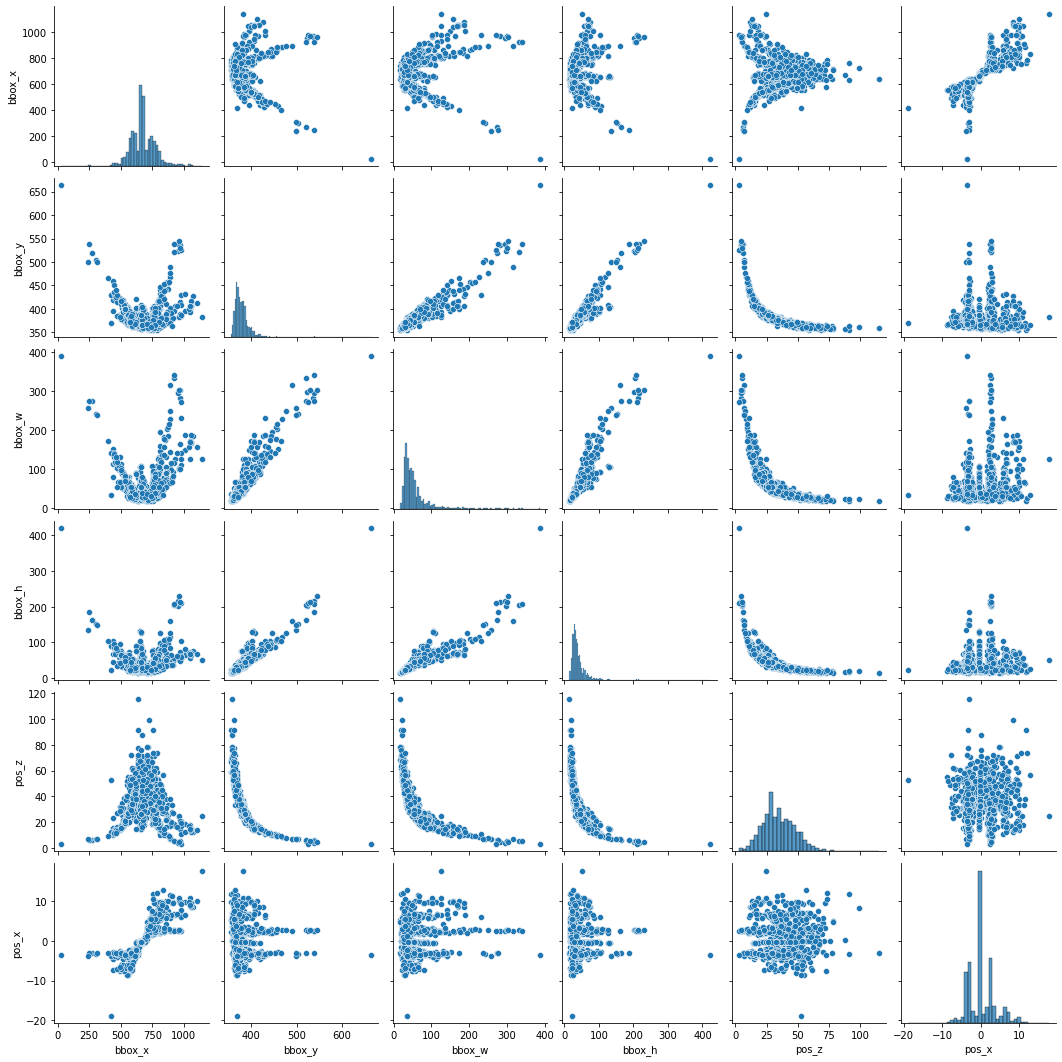

In [26]:
sns.pairplot(train_dataset)

# Split Training Data and Test Data Into Inputs and Targets

In [27]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_targets_z = train_features[['pos_z']].copy()
train_targets_x = train_features[['pos_x']].copy()
train_features = train_features.drop(['pos_z', 'pos_x'], axis=1)
test_targets_z = test_features[['pos_z']].copy()
test_targets_x = test_features[['pos_x']].copy()
test_features = test_features.drop(['pos_z', 'pos_x'], axis=1)

In [28]:
print(train_features.tail())
print(train_targets_z.tail())
print(train_targets_x.tail())
print(test_features.tail())
print(test_targets_z.tail())
print(test_targets_x.tail())

           bbox_x      bbox_y      bbox_w     bbox_h
1437  1046.741211  406.767700  168.736328  66.928101
1438   773.009827  365.354767   39.833374  25.436249
1439   706.252197  366.899445   35.494751  32.151764
1440   740.595398  361.888641   31.212524  21.840363
1441   572.182068  371.794312   29.412231  22.727081
          pos_z
1437  14.692977
1438  40.494133
1439  44.793174
1440  56.692773
1441  49.080213
         pos_x
1437  8.889901
1438  5.500969
1439  1.314025
1440  5.480445
1441 -6.737765
         bbox_x      bbox_y     bbox_w     bbox_h
370  596.311401  384.143127  50.038757  36.870026
371  686.086121  389.359009  74.326416  75.383423
372  728.255493  368.727081  30.102661  24.745697
373  803.424011  370.364624  42.303345  26.000122
374  658.999817  380.924774  50.237305  35.684174
         pos_z
370  29.080471
371  23.094960
372  43.586416
373  39.631952
374  28.729463
        pos_x
370 -2.712433
371 -0.390961
372  2.367466
373  7.382388
374 -0.344463


# Scale Inputs Between -1 and 1

In [29]:
scaler = preprocessing.MinMaxScaler((-1, 1))
train_inputs = torch.from_numpy(scaler.fit_transform(train_features.values))
test_inputs = torch.from_numpy(scaler.transform(test_features.values))
train_expected_z = torch.from_numpy(train_targets_z.values)
train_expected_x = torch.from_numpy(train_targets_x.values)
test_expected_z = torch.from_numpy(test_targets_z.values)
test_expected_x = torch.from_numpy(test_targets_x.values)

# Train Pos Z Model

In [30]:
class NeuralRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(4, 240)
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(240, 1)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    return x

In [31]:
# def fit(num_epochs, model, train_inputs, train_expected, batch_size, loss_fn, opt, scheduler, test_input, test_expected):
#   ds = TensorDataset(train_inputs, train_expected)
#   dl = DataLoader(ds, batch_size, shuffle=True, drop_last=True)
#   for epoch in range(num_epochs):
#     model.train()
#     if epoch > 0 and scheduler:
#       scheduler.step()
#     for xb, yb, in dl:
#       pred = model(xb)
#       loss = loss_fn(pred, yb)
#       loss.backward()
#       opt.step()
#       opt.zero_grad()
#     model.eval()
#     if epoch % 100 == 0:
#       with torch.no_grad():
#         mae = nn.L1Loss()
#         train_loss = loss_fn(model(train_inputs), train_expected).item()
#         test_loss = loss_fn(model(test_inputs), test_expected).item()
#         train_mae = mae(model(train_inputs), train_expected).item()
#         test_mae = mae(model(test_inputs), test_expected).item()
#         print(f'[Epoch: {epoch}] Train Loss: {train_loss:20} Test Loss: {test_loss:20} Train MAE: {train_mae:20} Test MAE: {test_mae:20}')

In [32]:
# model_pos_z = NeuralRegressor().double()
# optimizer = torch.optim.SGD(model_pos_z.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.8)
# fit(4000, model_pos_z, 
#     train_inputs, train_expected_z, 
#     16, F.mse_loss, optimizer, scheduler,
#     test_inputs, test_expected_z
# )

# Evaluate Final Pos Z model

In [33]:
# model_pos_z.eval()
# print(F.mse_loss(model_pos_z(test_inputs), test_expected_z).item())
# print(nn.L1Loss()(model_pos_z(test_inputs), test_expected_z).item())

# Train Pos X Model

In [34]:
# model_pos_x = NeuralRegressor().double()
# optimizer = torch.optim.Adam(model_pos_x.parameters())
# fit(1000, model_pos_x, 
#     train_inputs, train_expected_x, 
#     16, F.mse_loss, optimizer, None,
#     test_inputs, test_expected_x
# )

# Evaluate Final Pos X Model

In [35]:
# model_pos_x.eval()
# print(F.mse_loss(model_pos_x(test_inputs), test_expected_x).item())
# print(nn.L1Loss()(model_pos_x(test_inputs), test_expected_x).item())

# Save Models To Disk

In [36]:
# SAVING MODEL
#torch.save(model_pos_z.state_dict(), './model_pos_z.pkl')
#torch.save(model_pos_x.state_dict(), './model_pos_x.pkl')

# Load Models From Disk

In [37]:
# LOADING SAVED MODEL
model_pos_z_loaded = NeuralRegressor()
model_pos_z_loaded.load_state_dict(torch.load('./model_pos_z.pkl'))
model_pos_z_loaded.double().eval()
model_pos_x_loaded = NeuralRegressor()
model_pos_x_loaded.load_state_dict(torch.load('./model_pos_x.pkl'))
model_pos_x_loaded.double().eval()

NeuralRegressor(
  (linear1): Linear(in_features=4, out_features=240, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=240, out_features=1, bias=True)
)

# Evaluate Loaded Models

In [45]:
model_pos_z_loaded.eval()
print('MSE:', F.mse_loss(model_pos_z_loaded(test_inputs), test_expected_z).item())
print('MAE:', nn.L1Loss()(model_pos_z_loaded(test_inputs), test_expected_z).item())

MSE: 10.299784590023085
MAE: 2.0559691245847556


In [46]:
model_pos_x_loaded.eval()
print('MSE:', F.mse_loss(model_pos_x_loaded(test_inputs), test_expected_x).item())
print('MAE:', nn.L1Loss()(model_pos_x_loaded(test_inputs), test_expected_x).item())

MSE: 0.10957210437132876
MAE: 0.21063153357679307


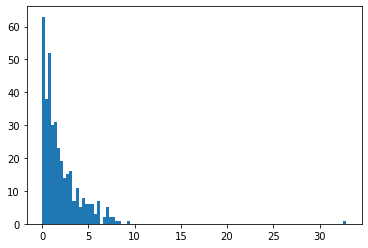

2.055969124584756


In [47]:
predicted_z = model_pos_z_loaded(test_inputs).detach().numpy()
truth_z = test_targets_z.to_numpy()

errors_z = np.absolute(np.subtract(predicted_z, truth_z))

plt.hist(errors_z, bins=100)
plt.show()

print(np.mean(errors_z))

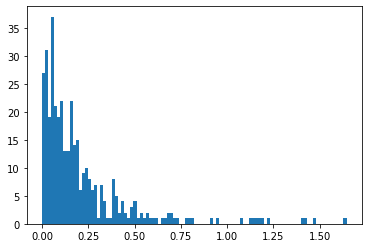

0.21063153357679312


In [48]:
predicted_x = model_pos_x_loaded(test_inputs).detach().numpy()
truth_x = test_targets_x.to_numpy()

errors_x = np.absolute(np.subtract(predicted_x, truth_x))

plt.hist(errors_x, bins=100)
plt.show()
print(np.mean(errors_x))

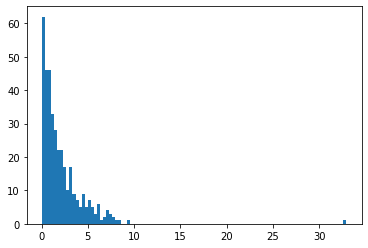

2.0845140309489003


In [49]:
euclidean_errors = np.sqrt((errors_z * errors_z) + (errors_x * errors_x))

plt.hist(euclidean_errors, bins=100)
plt.show()

print(np.mean(euclidean_errors))

In [50]:
predicted_distances = np.sqrt((predicted_z  * predicted_z) + (predicted_x * predicted_x))
true_distances = np.sqrt((truth_z  * truth_z) + (truth_x * truth_x))
percentage_errors = np.absolute(predicted_distances - true_distances)/true_distances
print(np.mean(percentage_errors) * 100)
print(np.mean(np.absolute(predicted_distances - true_distances)))

5.2051219318952215
2.066404627933593
